# Requirements
### Goal. 
Based on the dataset description in Kaggle, describe the goal of the A/B test. Give any necessary context.
Target metric. Choose a target metric and describe how it measures progress towards the stated goal of the A/B test.


### Calculations.
- In your notebook, aggregate and prepare data as needed. Report key information about the A/B test, including the sample size and variant proportions.
- Conduct statistical tests. Describe which test you have chosen for each metric and why.
- Report the estimated v40 effect, confidence interval and p-value. For one of the datasets, compute the confidence interval both analytically and using bootstrap and report both intervals.
### Decision. 
Describe clearly what your calculations imply and which decision you recommend. Use visualizations to show differences in the metric between groups and confidence intervals.

---

### Goal of the A/B Test:
The A/B test is likely testing whether the new version of the game (gate_40) increases user retention (both short-term after 1 day and long-term after 7 days) and/or engagement (measured by the number of game rounds played).

### Target Metric:
- Retention after 1 day: Proportion of users who returned after 1 day (retention_1).
- Retention after 7 days: Proportion of users who returned after 7 days (retention_7).
- The total number of game rounds played (sum_gamerounds).

---

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from statsmodels.stats.proportion import proportions_ztest

In [4]:
sns.set(rc = {'figure.figsize':(14,4)})

In [5]:
# Path of the file to read
filepath = "cookie_cats.csv"

# Read the file into a variable
df = pd.read_csv(filepath)#, index_col="Date", parse_dates=True)

In [6]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [7]:
print(df[df.isnull().any(axis=1)])

Empty DataFrame
Columns: [userid, version, sum_gamerounds, retention_1, retention_7]
Index: []


No missing data.

## Calculations

### Odd rows deletion.

Odd for analysis rows were found in the dataset, which are to be deletted at the beginning.

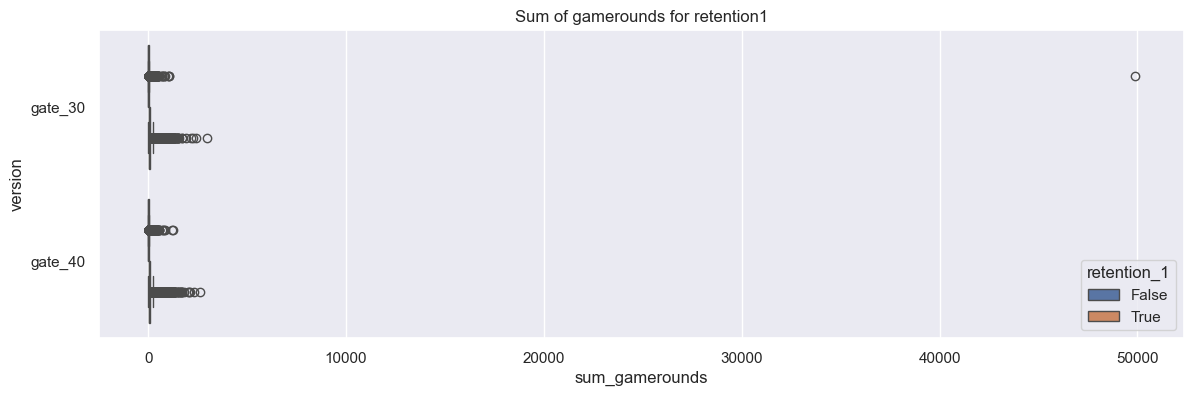

In [8]:
sns.boxplot(data=df, x='sum_gamerounds', y='version', hue='retention_1')
plt.title(f'Sum of gamerounds for retention1', fontsize=12)
plt.show()

There is one point standing far from the other points with a value around 50000. Dataset desription says 'sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.'

There would be around 25 seconds gap between each gameround to play without disruptions during that 14 days. 

This point is obvious anomaly and is to be deleted not to skew the analysis for gamerounds.

In [9]:
df.groupby('version')['sum_gamerounds'].aggregate(['count', 'min', 'max', 'mean', 'sum'])

,count,min,max,mean,sum
version,,,,,
gate_30,44700,0,49854,52.456264,2344795
gate_40,45489,0,2640,51.298776,2333530


It is seen from the table shown above, that there are users with 0 gamerounds. 

As the goal of this analysis is to find a better version (gate at 30th of at the 40th level) users with 0 gamerounds can not achieve any of these levels hence these rows are to be deleted from the analysis.

In [10]:
print(f"Number of rows with zero gamerounds: {len(df[df['sum_gamerounds']==0])}")

Number of rows with zero gamerounds: 3994


In [11]:
df = df[df['sum_gamerounds'].between(1, 10000)]

### Sample sizes

In [12]:
df.groupby('version')['sum_gamerounds'].aggregate(['count', 'min', 'max', 'mean', 'sum'])

,count,min,max,mean,sum
version,,,,,
gate_30,42762,1,2961,53.667766,2294941
gate_40,43432,1,2640,53.728357,2333530


__There are 42762 users seen 'gate_30' version and 43432 - 'gate_40'.__

### Retention and gameround comparison for different versions

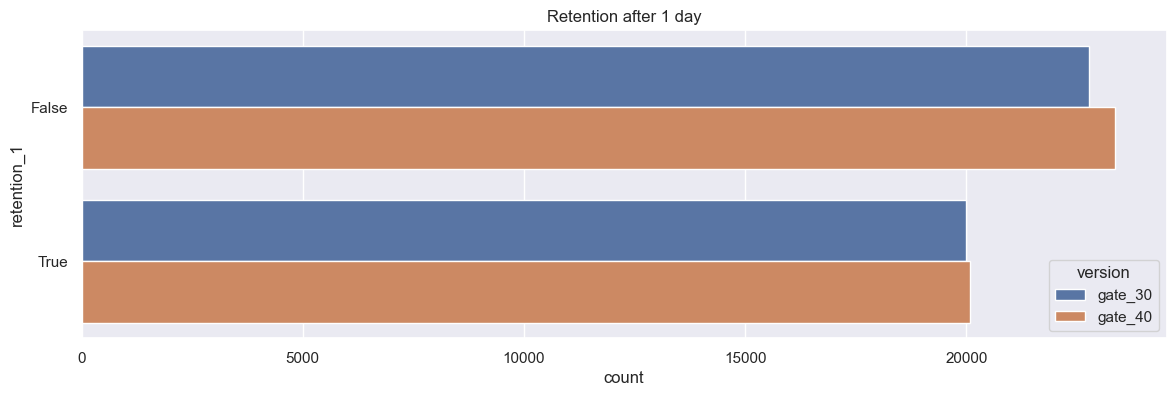

In [13]:
sns.countplot(data=df, y='retention_1', hue='version')
plt.title(f'Retention after 1 day', fontsize=12)
plt.show()

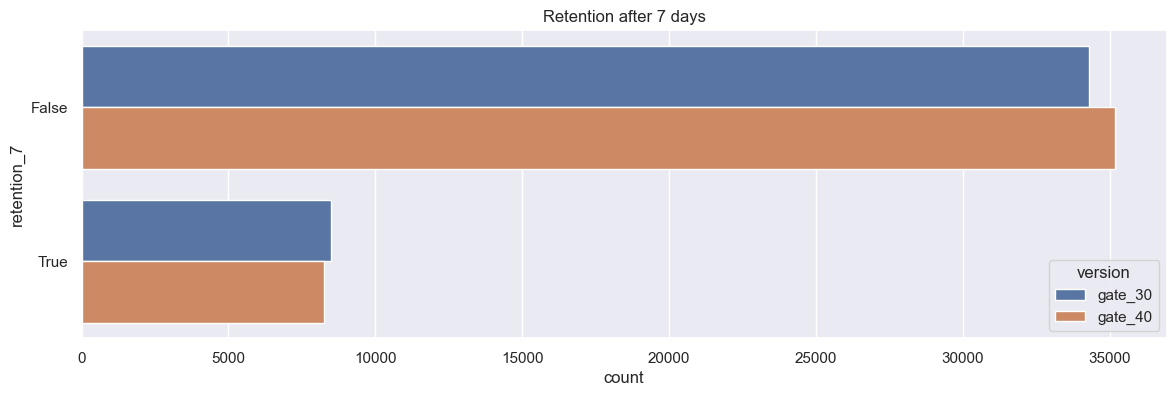

In [14]:
sns.countplot(data=df, y='retention_7', hue='version')
plt.title(f'Retention after 7 days', fontsize=12)
plt.show()

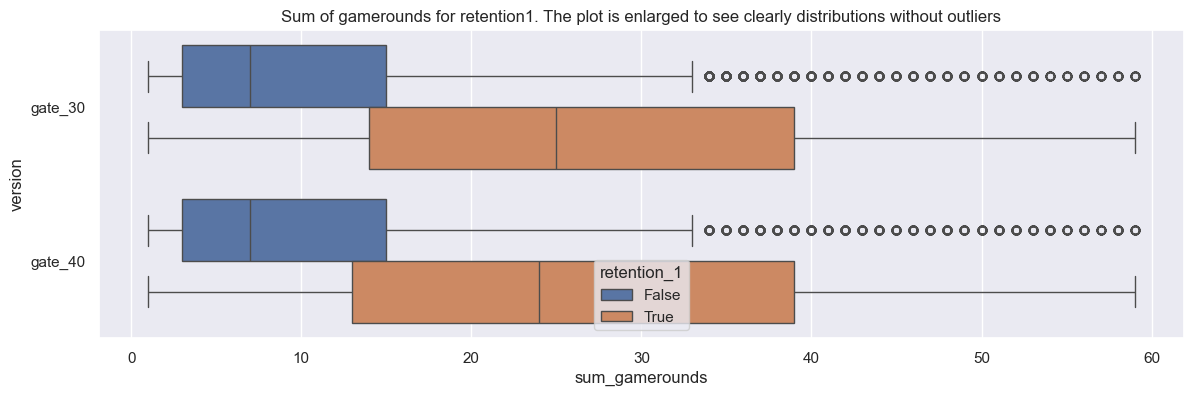

In [15]:
sns.boxplot(data=df[df['sum_gamerounds']<60], x='sum_gamerounds', y='version', hue='retention_1')
plt.title(f'Sum of gamerounds for retention1. The plot is enlarged to see clearly distributions without outliers', fontsize=12)
plt.show()

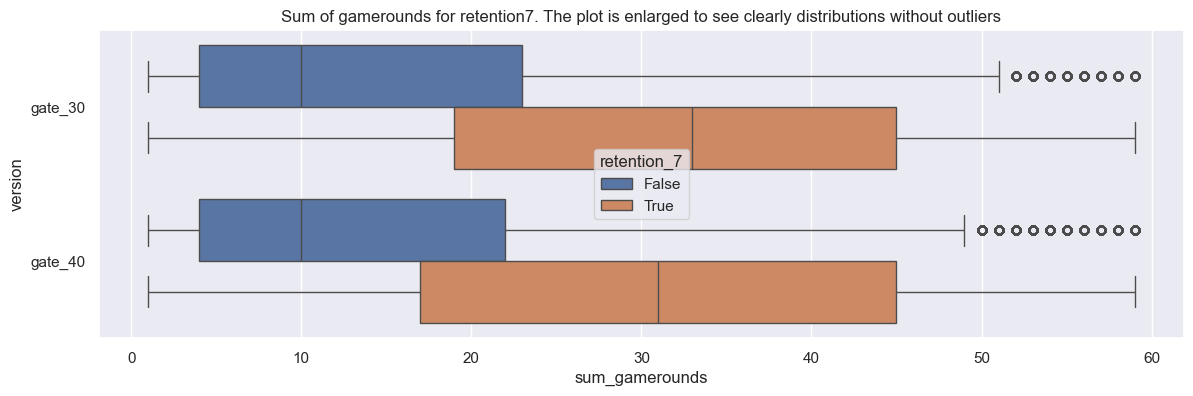

In [16]:
sns.boxplot(data=df[df['sum_gamerounds']<60], x='sum_gamerounds', y='version', hue='retention_7')
plt.title(f'Sum of gamerounds for retention7. The plot is enlarged to see clearly distributions without outliers', fontsize=12)
plt.show()

It is seen from the plots shown above that retention after 1 day and after 7 days and also gamerounds distibutions don't differ much for different versions.

## Means with confidence intervals plot

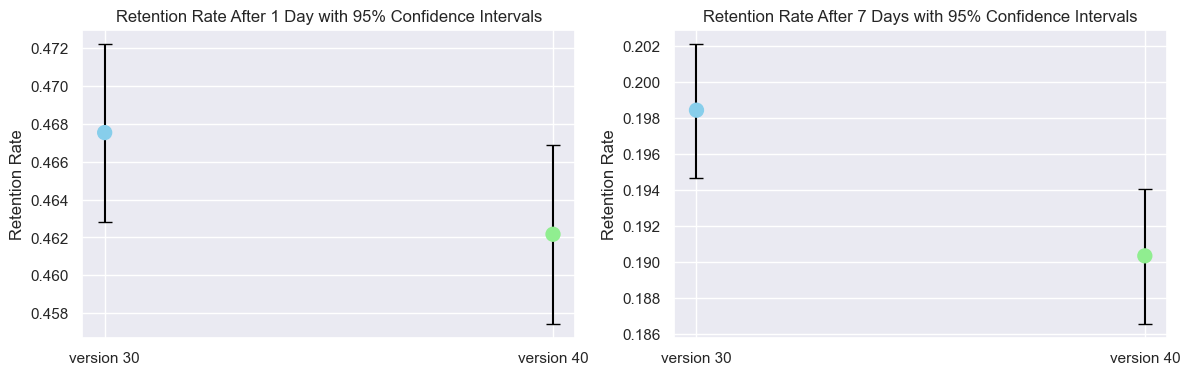

In [17]:
# Sample sizes for v30 and v40
total_v30 = len(df[df['version'] == 'gate_30'])
total_v40 = len(df[df['version'] == 'gate_40'])

fig, (ax1, ax2) = plt.subplots(1, 2)
plot_number = 1

for i in [1, 7]:
    retention_v30 = df[df['version'] == 'gate_30'][f'retention_{i}'].mean()
    retention_v40 = df[df['version'] == 'gate_40'][f'retention_{i}'].mean()
    
    # Standard error for the proportions
    se_v30 = np.sqrt((retention_v30 * (1 - retention_v30)) / total_v30)
    se_v40 = np.sqrt((retention_v40 * (1 - retention_v40)) / total_v40)
    
    # Z-value for 95% confidence interval
    z_value = 1.96
    
    # Confidence intervals
    ci_v30 = [retention_v30 - z_value * se_v30, retention_v30 + z_value * se_v30]
    ci_v40 = [retention_v40 - z_value * se_v40, retention_v40 + z_value * se_v40]
    
    # Create plot
    # fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot points for retention rates
    exec(f"ax{plot_number}.scatter(['version 30', 'version 40'], [retention_v30, retention_v40],               color=['skyblue', 'lightgreen'], s=100, zorder=5)")
    
    # Add confidence intervals as vertical error bars
    exec(f"ax{plot_number}.errorbar(['version 30', 'version 40'], [retention_v30, retention_v40], \
                yerr=[[retention_v30 - ci_v30[0]], [ci_v40[1] - retention_v40]], \
                fmt='none', color='black', capsize=5, zorder=4)")
    
    # Labels and title
    exec(f"ax{plot_number}.set_ylabel('Retention Rate')")
    exec(f"ax{plot_number}.set_title(f'Retention Rate After {i} Day{'s' if plot_number == 2 else ''} with 95% Confidence Intervals')")
    
    plot_number += 1

plt.show()

#### Retentions test

To test whether the differences in retention (1 and 7) are statistically significant, a two-sample z-test for proportions (retention rates) can be performed.

H0: gate_30 = gate_40 -> There is no statistically significant difference between retention after 1 day for different game versions.

H1: gate_30 != gate_40 -> There is a statistically significant difference between retention after 1 day for different game versions.

Similar hypothesys for retention after days.

In [18]:
# Count of users who retained and total users in each group
g30_retained1 = df[(df['version'] == 'gate_30')]['retention_1'].sum()
g40_retained1 = df[(df['version'] == 'gate_40')]['retention_1'].sum()

g30_retained7 = df[(df['version'] == 'gate_30')]['retention_7'].sum()
g40_retained7 = df[(df['version'] == 'gate_40')]['retention_7'].sum()

g30_total = len(df[df['version'] == 'gate_30'])
g40_total = len(df[df['version'] == 'gate_40'])

stat, p_value = proportions_ztest([g30_retained1, g40_retained1], [g30_total, g40_total])
print('Retention after 1 day test result:')
print(f"Z-statistic: {stat:.3f}")
print(f"P-value: {p_value:.4f}")

stat, p_value = proportions_ztest([g30_retained7, g40_retained7], [g30_total, g40_total])
print('\nRetention after 7 days test result:')
print(f"Z-statistic: {stat:.3f}")
print(f"P-value: {p_value:.4f}")

Retention after 1 day test result:
Z-statistic: 1.581
P-value: 0.1140

Retention after 7 days test result:
Z-statistic: 3.006
P-value: 0.0026


Since p-value (0.114) is greater than 0.05 for Retention 1 test, hence rejection of the null hypothesis is failed. There is insufficient evidence to conclude that the gate_40 version significantly increases/decreases 1-day retention compared to the gate_30 version at the 5% significance level.

P-value (0.0026) is less than 0.05 for Retention 7 test. Hence there is enough evidence to reject the null hypothesis (that versions have the same/similar result for retention after 7 days). So there is confirmed difference in retentions for the versions.

### gamerounds test

In [19]:
df.groupby('version')['sum_gamerounds'].aggregate(['count', 'mean', 'min', 'std', 'max'])

,count,mean,min,std,max
version,,,,,
gate_30,42762,53.667766,1,103.743691,2961
gate_40,43432,53.728357,1,105.093012,2640


H0: gate_30 = gate_40 -> There is no statistically significant difference between gamerounds for different game versions.

H1: gate_30 != gate_40 -> There is a statistically significant difference between gamerounds for different game versions.

In [20]:
import scipy.stats as stats

# Example: Load your raw data as lists or arrays
gate_30 = df[df['version']=='gate_30']['sum_gamerounds']  # Raw data for gate_30
gate_40 = df[df['version']=='gate_40']['sum_gamerounds']  # Raw data for gate_40

# Perform Welch's t-test
t_stat, p_value = stats.ttest_ind(gate_30, gate_40, equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -0.08518063202473634
p-value: 0.9321179858600119


Since p-value (0.93) is huge and is much greater than 0.05 for gamerounds test, hence rejection of the null hypothesis is failed. There is insufficient evidence to conclude that the versions have sufficiently different gamerounds.

## Conclusion
There is statistical evidence that version40 has higher retention rate after 7 days than version30.

There is no statistically significant difference for retention rate after 1 day for different game versions.

There is no statistically significant difference for sum of gamerounds for different game versions.

__Only one metric (of three) shows that there is statistically significant difference for different game versions__